In [216]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import mean_squared_error

from itertools import cycle

In [49]:
sns.set()
sns.set_style("whitegrid")
%matplotlib inline

# Utilities

In [161]:
def read_dataset(path, names=["x", "y"], dtype=None):
    return pd.read_csv(path, sep='\s+', names=names, dtype=dtype)
    
def read_with_gt(path, gt_path, normalize=True):
    dataset = read_dataset(path)
    if normalize:
         dataset=(dataset-dataset.mean())/dataset.std() #normalize data

    gt = read_dataset(gt_path, names=["cluster"])
    gt["cluster"] = gt["cluster"].astype(str)
    dataset_gt = pd.concat([dataset, gt], axis=1, sort=False)

    return dataset, dataset_gt
    
def plot_dataset(dataset, figsize=(15, 10), title=''):
    plt.figure(figsize=figsize)
    ax = sns.scatterplot(x="x", y="y", data=dataset).set_title(title)
    plt.show()
    
def plot_dataset_with_gt(dataset, gt, titles=("", ""), figsize=(20, 10)):
    _, axes = plt.subplots(1, 2, figsize=figsize)
    sns.scatterplot(x="x", y="y", data=dataset, size=1, ax=axes[0]).set_title(titles[0])
    sns.scatterplot(
        x="x", y="y", data=gt, hue='cluster', size=1, ax=axes[1], 
        palette=sns.color_palette("Set2", len(gt["cluster"].unique())),
    ).set_title(titles[1])
    axes[1].legend()
    plt.show()

# Datasets

Datasets (S-sets and G2-sets) are taken from ["Clustering basic benchmark"](https://cs.joensuu.fi/sipu/datasets/)

In [164]:
s_datasets = [
    read_with_gt(
        './tracking_datasets/s_datasets/s{}.txt'.format(i), 
        './tracking_datasets/s_datasets/s{}-label.txt'.format(i)
    ) 
    for i in range(1, 5)
]

g_datasets = [
    read_with_gt(
        './tracking_datasets/g_datasets/g2-2-{}.txt'.format(i), 
        './tracking_datasets/g_datasets/g2-2-{}-gt.txt'.format(i)
    ) 
    for i in range(30, 51, 20)
]

### S-sets with ground truth

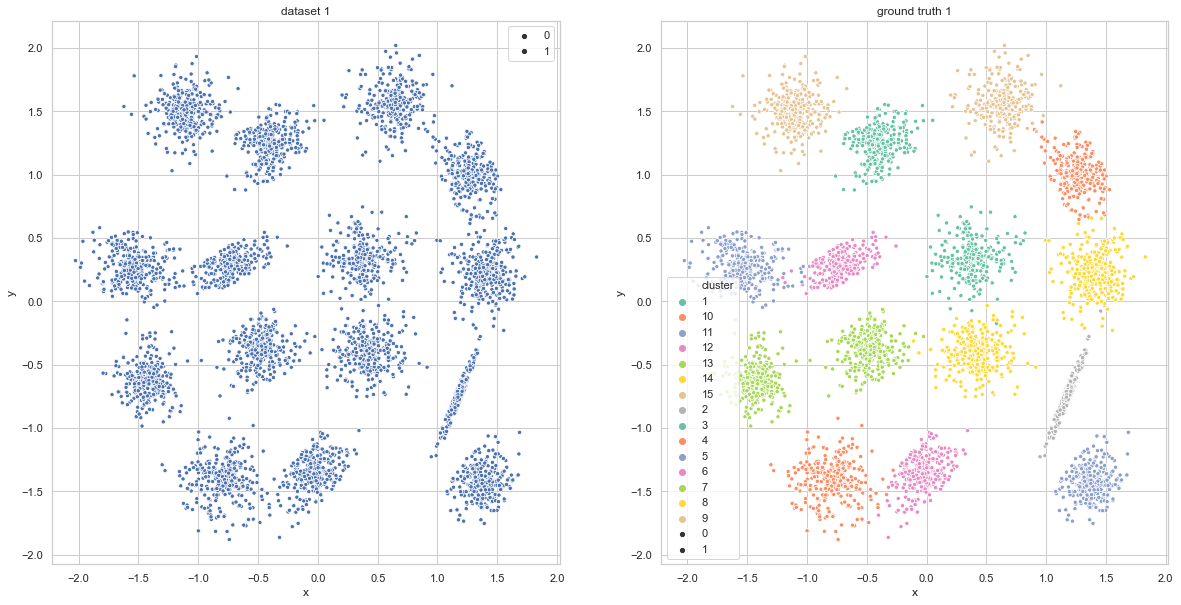

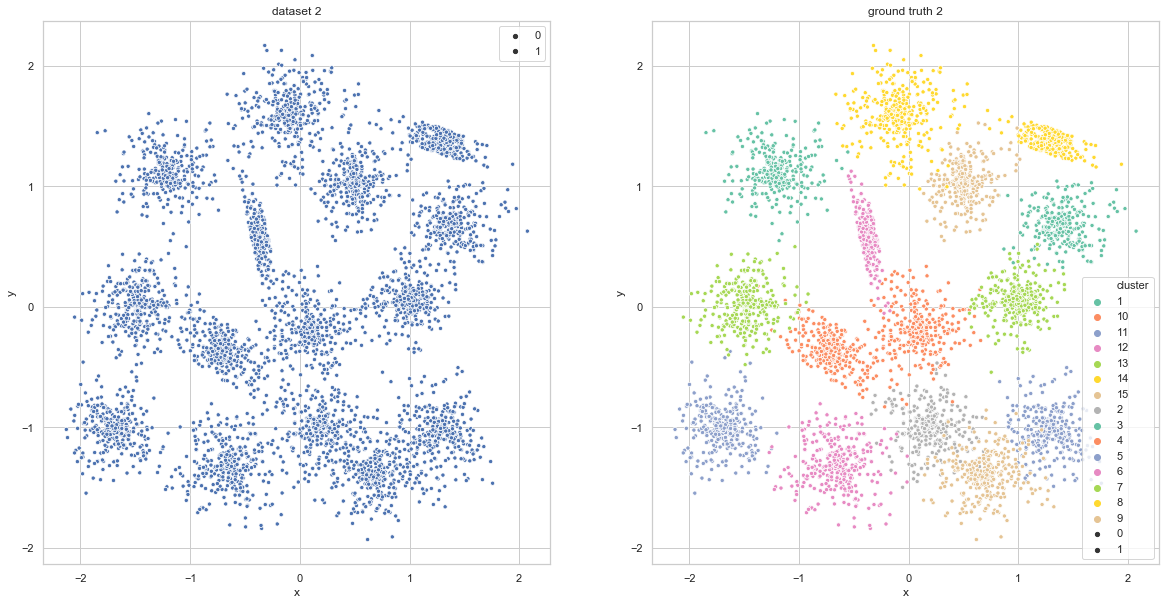

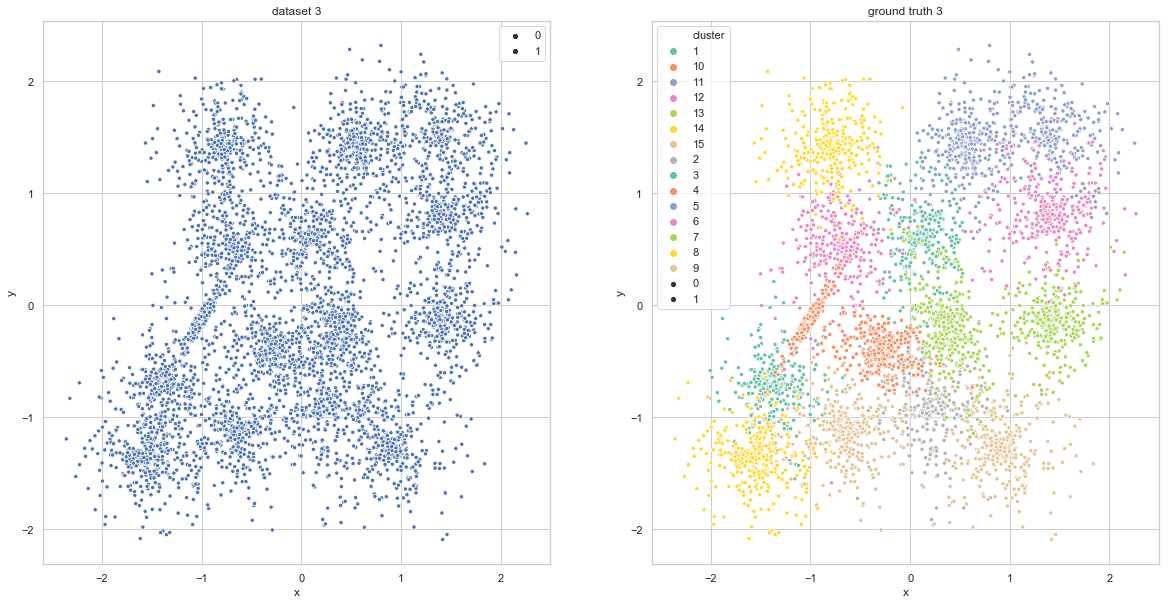

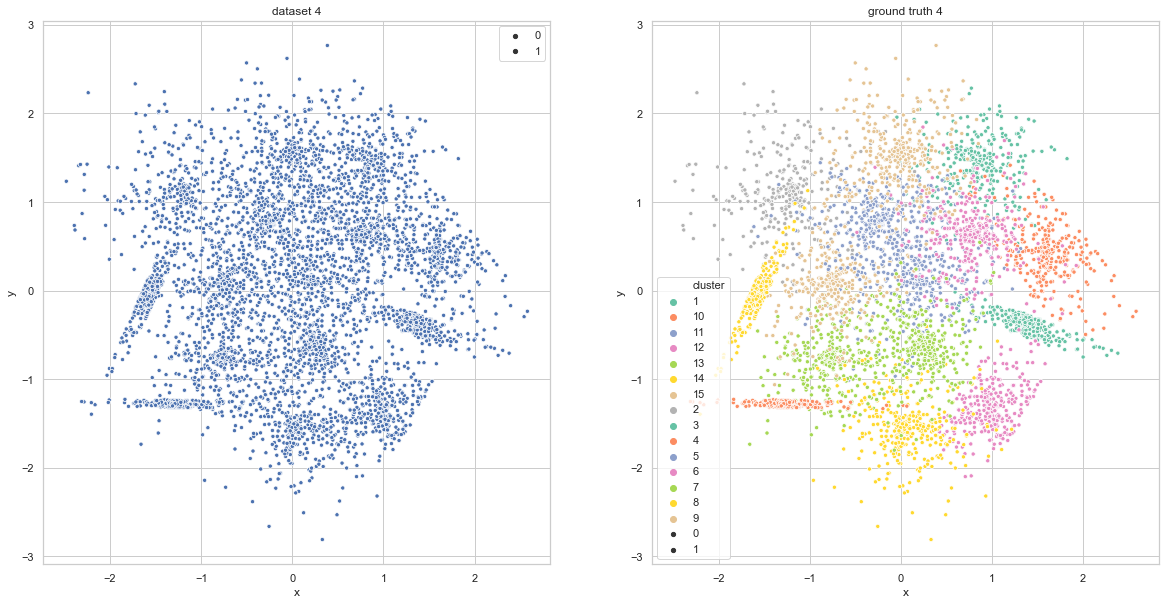

In [165]:
for i, (s, s_gt) in enumerate(s_datasets):
    plot_dataset_with_gt(s, s_gt, titles=("dataset {}".format(i + 1), "ground truth {}".format(i + 1)))

### G2-sets with ground truth

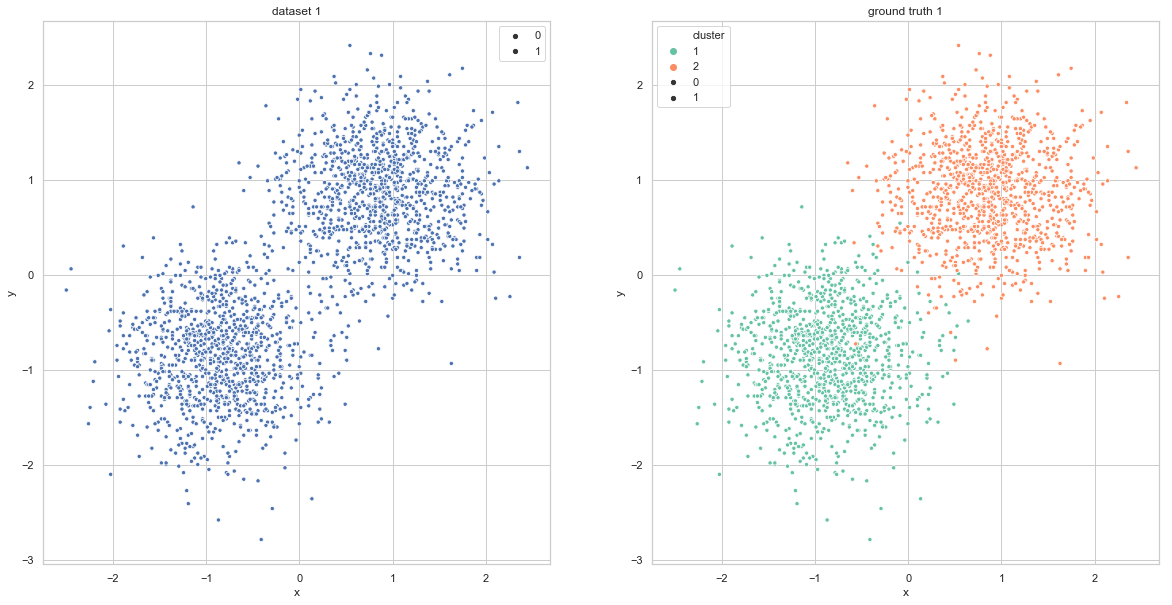

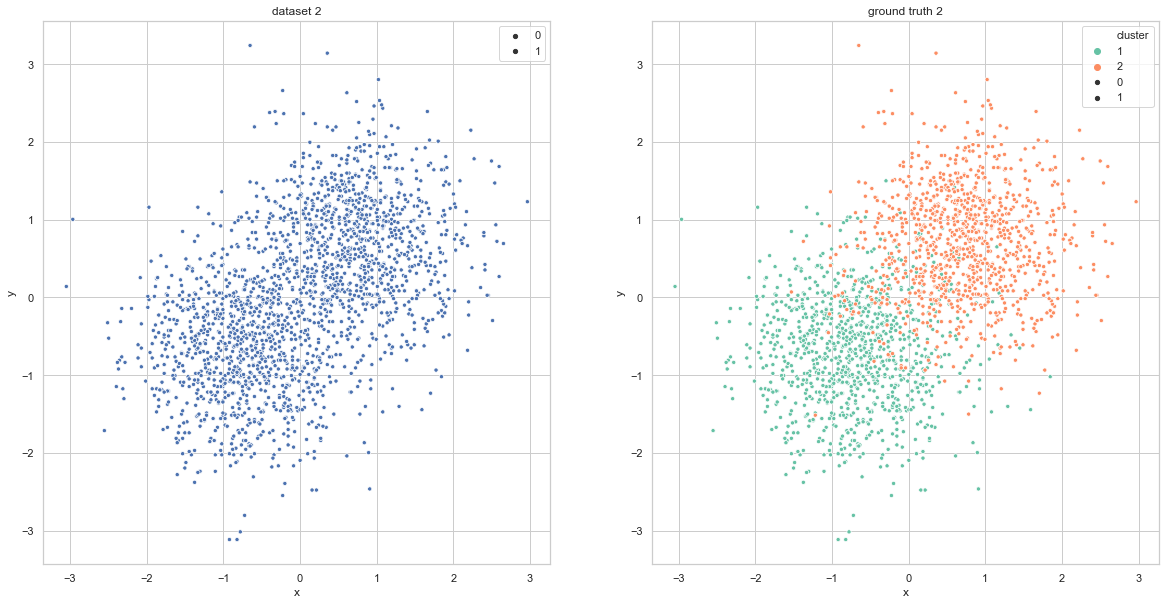

In [166]:
for i, (g, g_gt) in enumerate(g_datasets):
    plot_dataset_with_gt(g, g_gt, titles=("dataset {}".format(i + 1), "ground truth {}".format(i + 1)))

# Mean shift clustering

In [232]:
class MeanShiftClustering:
    def __init__(self, df):
        self.df = df
        self.labels = None
    
    def cluster(self, quantile=0.3):
        # The following bandwidth can be automatically detected using
        bandwidth = estimate_bandwidth(self.df, quantile=quantile)

        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(self.df)
        self.labels = ms.labels_
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(self.labels)
        self.n_clusters = len(labels_unique)

        print("number of estimated clusters : %d" % self.n_clusters)
        return self.labels, self.n_clusters
    
    def compare(self, ground_truth):
        return mean_squared_error(self.labels, ground_truth)
    
    def plot(self, ground_truth, figsize=(20, 10)):
        prediction = pd.concat([self.df, pd.DataFrame.from_dict({"cluster": self.labels})], axis=1, sort=False)
        _, axes = plt.subplots(1, 2, figsize=figsize)
        for i, (data, title) in enumerate([(prediction, "prediction"), (ground_truth, "groud_truth")]):
            sns.scatterplot(
                x="x", y="y", data=data, hue='cluster', size=1, ax=axes[i], 
                palette=sns.color_palette("Set2", len(data["cluster"].unique())),
            ).set_title(title)
            axes[i].legend()
        plt.show()

number of estimated clusters : 15
MSE=60.79


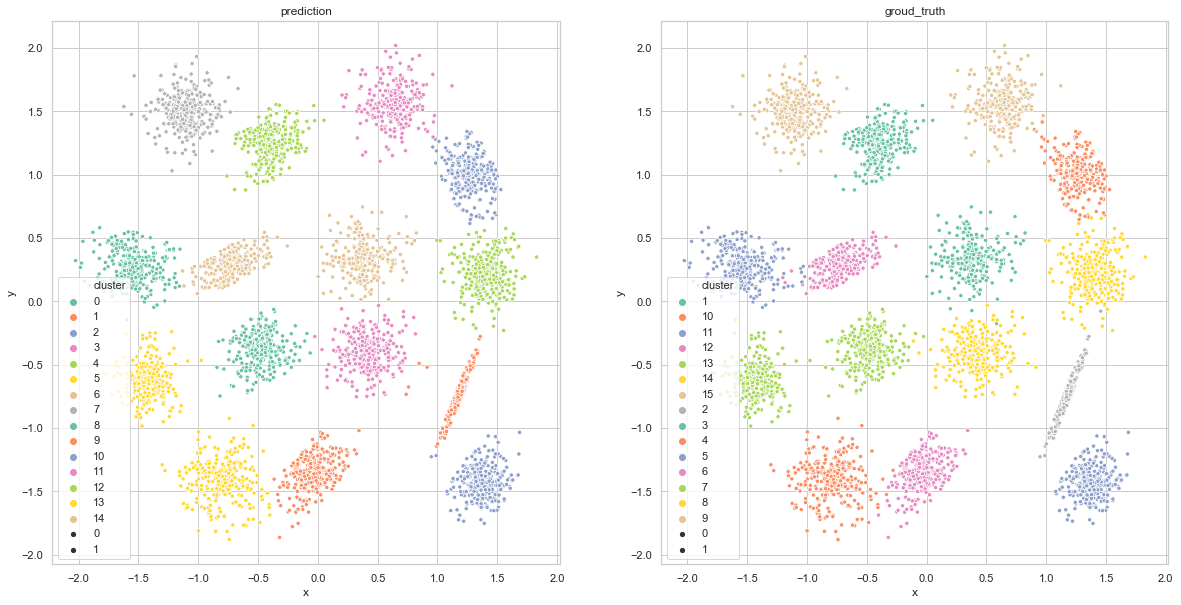

number of estimated clusters : 15
MSE=45.6288


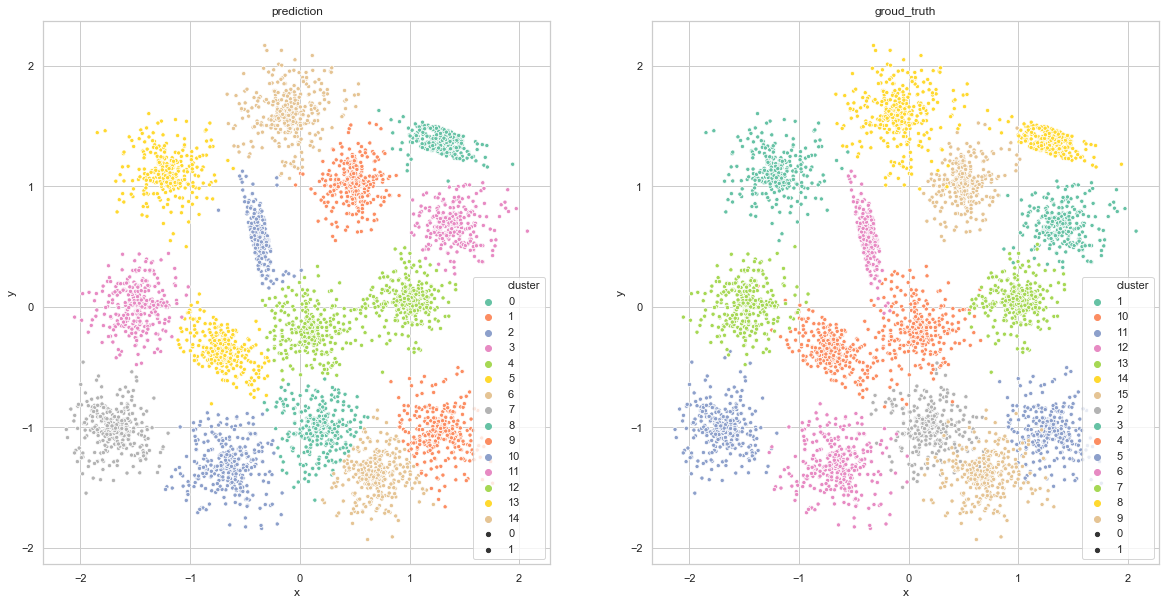

number of estimated clusters : 15
MSE=46.0732


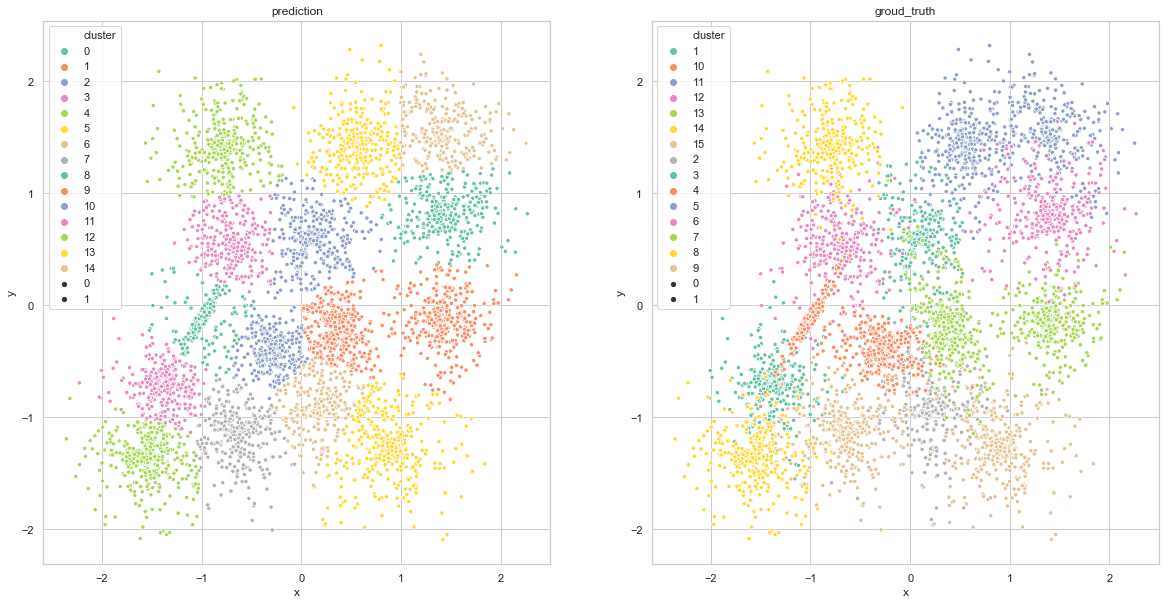

number of estimated clusters : 17
MSE=49.3508


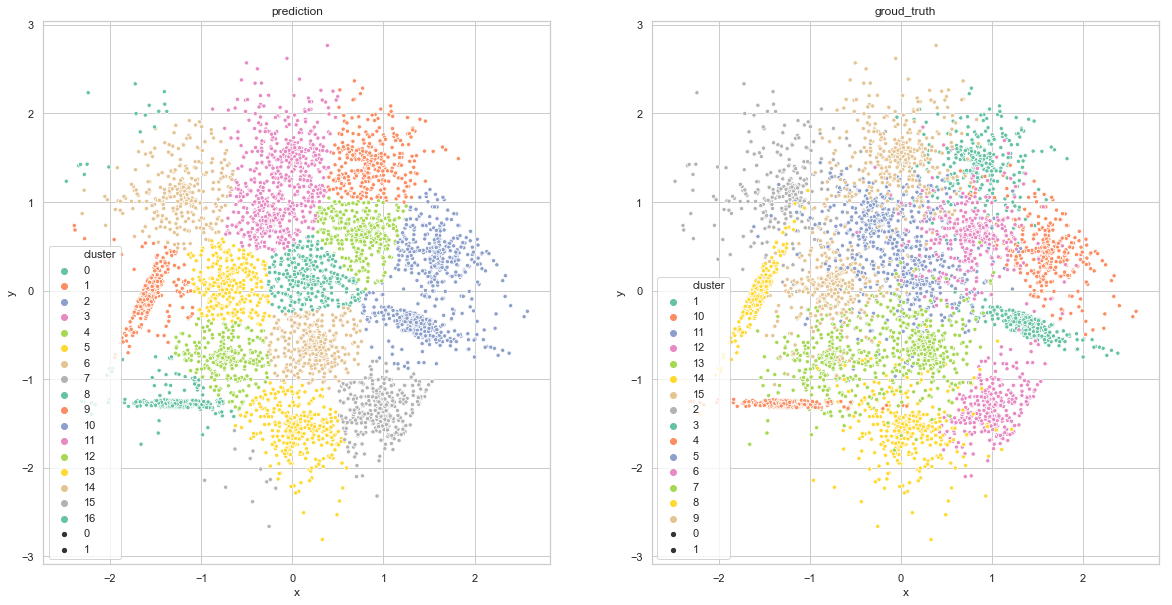

In [233]:
for i, (s, s_gt) in enumerate(s_datasets):
    ms = MeanShiftClustering(s)
    ms.cluster(quantile=0.05)
    error = ms.compare(s_gt['cluster'])
    print("MSE={}".format(error))
    ms.plot(s_gt)

number of estimated clusters : 2
MSE=1.015625


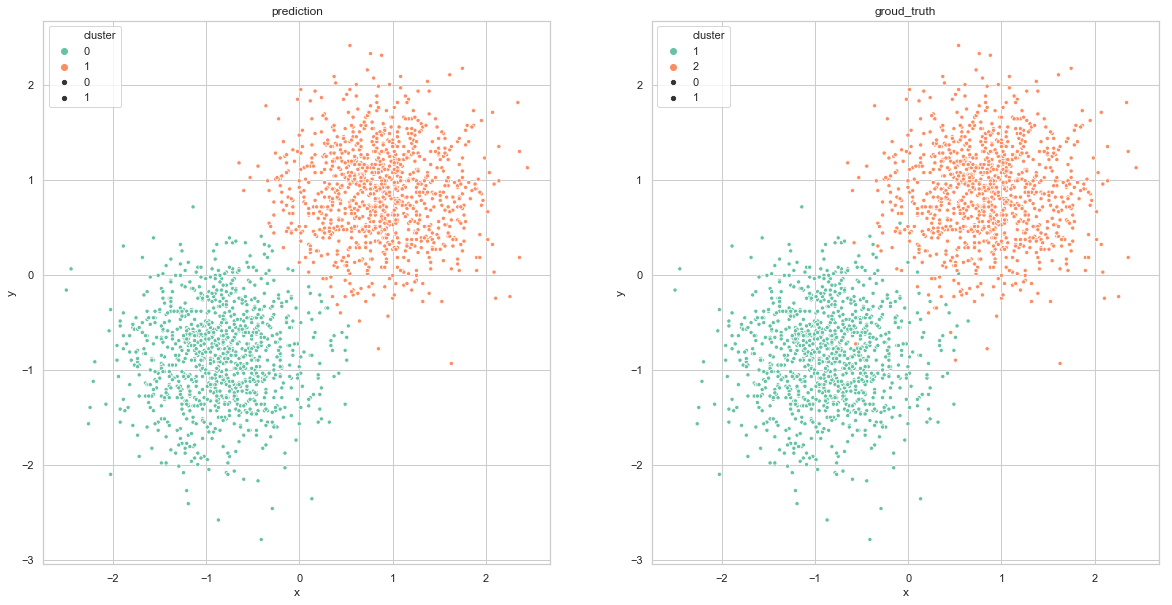

number of estimated clusters : 2
MSE=1.1064453125


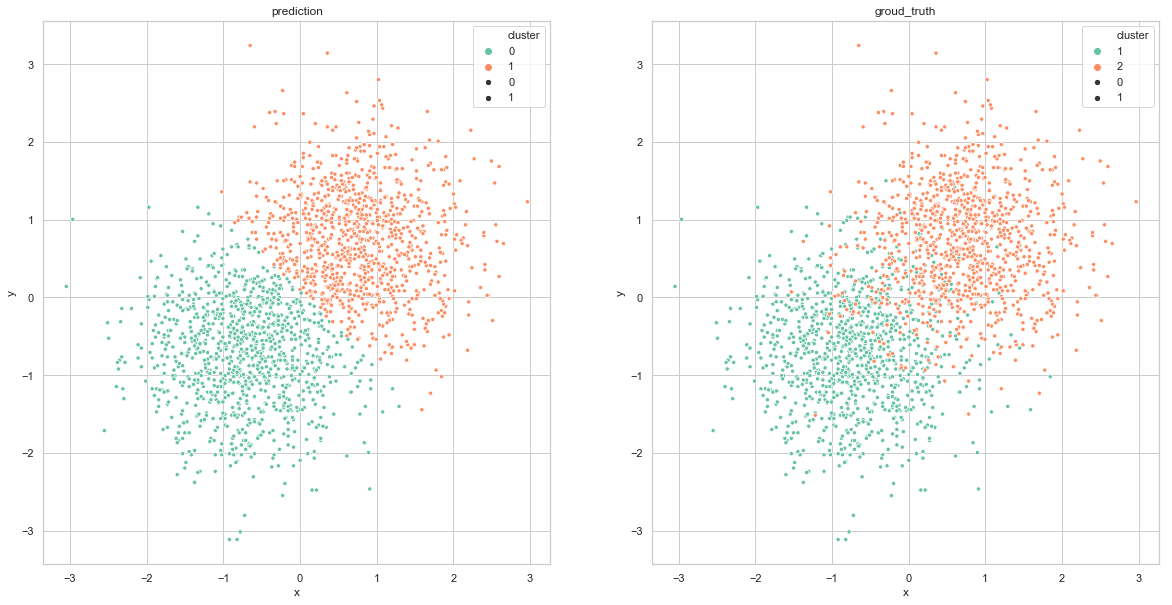

In [236]:
for i, (g, g_gt) in enumerate(g_datasets):
    ms = MeanShiftClustering(g)
    ms.cluster(quantile=0.3)
    error = ms.compare(g_gt['cluster'])
    print("MSE={}".format(error))
    ms.plot(g_gt)